Эта программа использует нейронные сети, а именно модель **LSTM** (**Long Short-Term Memory**), для прогнозирования цен закрытия акций на будущее. Давайте разберем, как программа работает:

1. **Обучение модели:** Для каждого финансового инструмента (**AAPL**, **NWTN**, **PARA**, **AX**), программа загружает исторические данные о ценах закрытия с помощью yfinance.
Данные масштабируются в диапазоне от **0** до **1** с использованием **MinMaxScaler**.
Создаются временные шаги (**look_back**) для обучения модели. Каждый временной шаг представляет собой последовательность предыдущих цен закрытия.
Строится модель **LSTM** с несколькими слоями и обучается на исторических данных с использованием среднеквадратичной ошибки в качестве функции потерь.
2. **Прогнозирование будущих цен:** После обучения модели создаются прогнозы для будущего периода (**365** дней) для каждого инструмента.
Прогнозы масштабируются обратно в исходный диапазон цен.
3. **Оценка качества модели:** Производится оценка качества прогнозов с использованием нескольких метрик, таких как средняя абсолютная ошибка (**MAE**), среднеквадратическая ошибка (**MSE**), коэффициент детерминации (**R-квадрат**), медианная абсолютная ошибка (**MedAE**) и средняя абсолютная процентная ошибка (**MAPE**).
4. **Визуализация результатов:** Для каждого инструмента программа строит графики исходных данных и прогнозов.

Таким образом, программа предоставляет инвесторам инструмент для прогнозирования будущих цен закрытия акций для четырех различных финансовых инструментов. Процесс обучения и прогнозирования повторяется для каждого инструмента, и результаты визуализируются для дальнейшего анализа и принятия решений об инвестициях.

Выходные данные были обрезаны до нескольких последних строк (5000).
187/187 [==============================] - 2s 13ms/step - loss: 6.0682e-05 - mape: 426.2935
Epoch 245/500
187/187 [==============================] - 2s 11ms/step - loss: 5.5276e-05 - mape: 504.7474
Epoch 246/500
187/187 [==============================] - 2s 10ms/step - loss: 5.6813e-05 - mape: 277.9424
Epoch 247/500
187/187 [==============================] - 2s 11ms/step - loss: 5.6746e-05 - mape: 147.8105
Epoch 248/500
187/187 [==============================] - 2s 11ms/step - loss: 5.3728e-05 - mape: 448.5273
Epoch 249/500
187/187 [==============================] - 2s 12ms/step - loss: 5.9527e-05 - mape: 356.5434
Epoch 250/500
187/187 [==============================] - 3s 15ms/step - loss: 6.7012e-05 - mape: 274.7705
Epoch 251/500
187/187 [==============================] - 2s 10ms/step - loss: 5.6378e-05 - mape: 796.5173
Epoch 252/500
187/187 [==============================] - 2s 10ms/step - loss: 5.8087e-05 - mape: 4

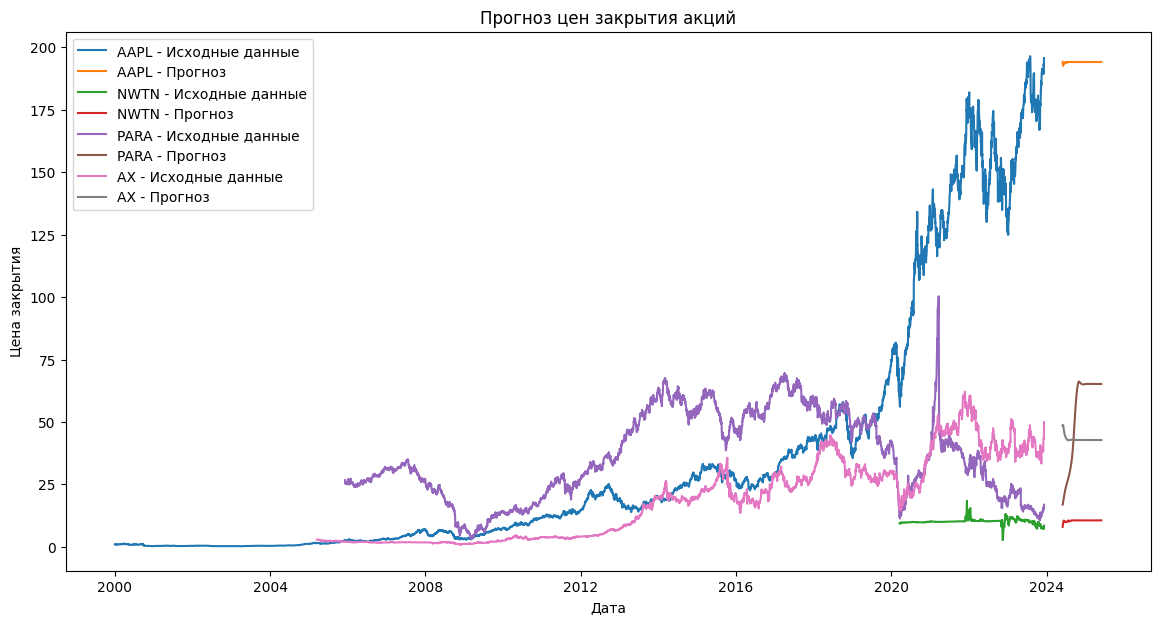

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

def train_model(symbol, epochs=500, batch_size=32):
    stock_data = yf.download(symbol, start="2000-01-01", end="2023-12-31")

    closing_prices = stock_data['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    closing_prices_scaled = scaler.fit_transform(closing_prices)

    look_back = 60
    X, y = [], []

    for i in range(len(closing_prices_scaled) - look_back):
        X.append(closing_prices_scaled[i:(i + look_back), 0])
        y.append(closing_prices_scaled[i + look_back, 0])

    X, y = np.array(X), np.array(y)
    X_train = np.reshape(X, (X.shape[0], X.shape[1], 1))

    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mape'])
    model.fit(X_train, y, epochs=epochs, batch_size=batch_size)

    return model, scaler, stock_data

def predict_future_prices(model, scaler, stock_data, future_period=365):
    closing_prices_scaled = scaler.transform(stock_data['Close'].values.reshape(-1, 1))

    future_prices = []

    for i in range(future_period):
        last_X = closing_prices_scaled[-look_back:]
        last_X = np.reshape(last_X, (1, look_back, 1))
        forecast = model.predict(last_X)
        future_prices.append(forecast[0, 0])
        closing_prices_scaled = np.append(closing_prices_scaled, forecast, axis=0)

    future_prices = np.array(future_prices).reshape(-1, 1)
    future_prices = scaler.inverse_transform(future_prices)

    return future_prices

def evaluate_model(model, scaler, stock_data, future_prices, future_period=365):
    actual_prices_future = stock_data['Close'].values[-future_period:]

    X_test = np.reshape(X[-future_period:], (future_period, look_back, 1))
    y_test_pred = model.predict(X_test)
    y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1))

    mae = mean_absolute_error(actual_prices_future, future_prices)
    mse = mean_squared_error(actual_prices_future, future_prices)
    r2 = r2_score(actual_prices_future, future_prices)
    medae = median_absolute_error(actual_prices_future, future_prices)
    mape_test = mean_absolute_percentage_error(actual_prices_future, y_test_pred)

    print(f"Средняя абсолютная ошибка (MAE) для {symbol}: {mae:.2f}%")
    print(f"Среднеквадратическая ошибка (MSE) для {symbol}: {mse:.2f}%")
    print(f"R-в квадрате (R2) для {symbol}: {r2:.4f}%")
    print(f"Медианная абсолютная ошибка (MedAE) для {symbol}: {medae:.2f}%")
    print(f"Средняя абсолютная процентная ошибка (MAPE) тестовых данных для {symbol}: {mape_test:.2f}%")

# Обучение моделей
symbols = ["AAPL", "NWTN", "PARA", "AX"]
models = []
scalers = []
stock_data_list = []

for symbol in symbols:
    model, scaler, stock_data = train_model(symbol)
    models.append(model)
    scalers.append(scaler)
    stock_data_list.append(stock_data)

# Создание прогнозов для расширенного периода и оценка моделей
future_prices_list = []

for i, symbol in enumerate(symbols):
    future_prices = predict_future_prices(models[i], scalers[i], stock_data_list[i])
    future_prices_list.append(future_prices)
    evaluate_model(models[i], scalers[i], stock_data_list[i], future_prices)

# Визуализация прогнозов
plt.figure(figsize=(14, 7))
for i, symbol in enumerate(symbols):
    plt.plot(stock_data_list[i].index, stock_data_list[i]['Close'], label=f'{symbol} - Исходные данные')
    plt.plot(future_dates, future_prices_list[i], label=f'{symbol} - Прогноз')

plt.title('Прогноз цен закрытия акций')
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.show()
